# SpotiPy Connect & Web Scraping
I want to find out who I listen to and what their basic background is.
[Medium Article](https://medium.com/@RareLoot/extracting-spotify-data-on-your-favourite-artist-via-python-d58bc92a4330)
[Examples](https://github.com/plamere/spotipy/tree/master/examples)

In [3]:
# Spotify
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util
from client_secret import *
# General
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from datetime import date
import datetime as dt
import math
import time
import pprint as pp

import musicbrainzngs as brainz
from musicbrainzngs import AuthenticationError, ResponseError

## Spotify API Connection

In [4]:
def spotify_connect(user_scope, redirect_uri, artist_limit, time_range):
    """Connects to Spotify API, returning user's top artists"""
    
    # Load in secret keys
    client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
    client = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

    # Create security token
    security_token = util.prompt_for_user_token(username, user_scope, client_id=client_id, client_secret=client_secret, redirect_uri=redirect_uri)
    
    # Gets favourite artists 
    if security_token:
        spotify_client = spotipy.Spotify(auth=security_token)
        spotify_client.trace = False
        # Loop through time ranges
        for r in time_range:
            results = spotify_client.current_user_top_artists(time_range=r, limit=artist_limit)
            user = spotify_client.current_user()
            if 'display_name' in user:
                name = user['display_name']
        return results, name
    
scope = "user-top-read"
redirect_uri = "http://localhost:8080"

results,name = spotify_connect(scope, redirect_uri, 100, ['short_term', 'medium_term', 'long_term'])

### Load Results into DataFrame

In [5]:
def make_df(response):
    """Pass results from Spotfy API call and returns cleaned DataFrame"""
    items = pd.DataFrame(response['items'])
    # Drop unnecessary columns
    items = items.drop(['external_urls', 'href', 'id', 'images', 'uri'], axis=1)
    # Followes column needs cleaning
    for i in range(0, len(items)):
        items.followers[i] = items.followers[i]['total']

    return items.sort_values(by='popularity', ascending=False)  
    
artists = make_df(results)
artists.head()

<ipython-input-5-ccc2c0fe9ec3>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items.followers[i] = items.followers[i]['total']


,followers,genres,name,popularity,type
3,10884208,"[chicago rap, melodic rap]",Juice WRLD,100,artist
6,48145787,"[canadian hip hop, canadian pop, hip hop, pop ...",Drake,98,artist
37,11201910,[rap],Travis Scott,96,artist
1,22443749,"[canadian contemporary r&b, canadian pop, pop]",The Weeknd,95,artist
15,29948767,"[electropop, pop]",Billie Eilish,92,artist


### Plot Favourites

<BarContainer object of 50 artists>

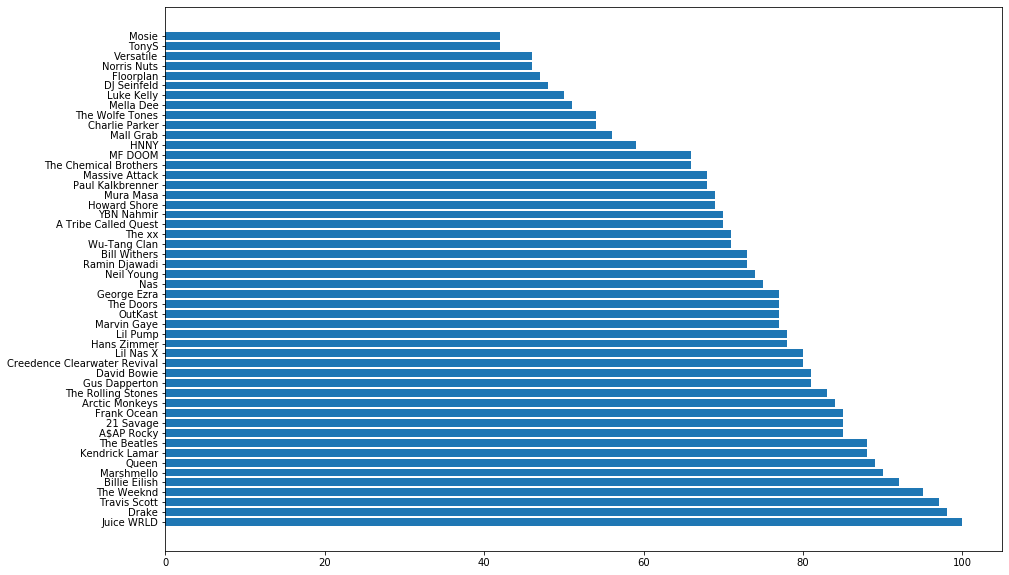

In [19]:
fig, ax = plt.subplots(figsize=(15,10))
ax.barh(artists.name, artists.popularity)

# Scrape Artist Ethnicity
https://ethnicelebs.com/

In [4]:
# from bs4 import BeautifulSoup as bs4
# import requests

## Scrape all paragraphs on page

In [5]:
# def get_paragraph(artist_name):
#     headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.71 Safari/537.36'}
#     base_url = "https://ethnicelebs.com/"
    
#     # Parsed artists name
#     parse_name = artist_name.replace(" ", "-")
#     req = requests.get(base_url+parse_name, headers=headers)
#     soup = bs4(req.content, "html.parser")

#     # Find all <p> elements
#     para = str(soup.find_all('p'))

#     # Find range of string
#     string_start = para.find("Ethnicity: ") + len("Ethnicity: ")
#     string_end = para.find("</strong")
#     race = para[string_start:string_end]
    
#     if len(race) < 100:
#         return race


&nbsp;
### Add races for each artist in df
Using BeautifulSoup is really slow.

In [6]:
# # Iterate over names and scrape
# races = []
# for artist in artists.name:
#     races.append(get_paragraph(artist))

In [7]:
# # Convert to Pandas Series and add to df
# artists_races = pd.Series( v for v in races )    
# artists['race'] = artists_races
# artists.head(5)

#### Plot specific races
This plot has many specific races which gives a very messy graph. Grouping the ethnicities and removing the None values would be an improvement

In [8]:
# fig, ax = plt.subplots(figsize=(22,7))
# artists.plot.barh(x ='race', y='popularity', ax=ax)

&nbsp;
### Group ethnicities
- The artists not found from scraping are 'Unknown
- Some *assumptions* for the other races

In [9]:
# artists.race.loc[ artists.race.isnull() == True ] = 'Unknown'
# artists.race.loc[ artists.race.str.contains('English|Irish|Jewish') == True ] = 'White'
# artists.race.loc[ artists.race.str.contains('African|Black|Ethiopian') == True ] = 'Black'

#### Plot grouped races
- count() prevents popularity playing a role in the numbers
- unstack() breaks the groupby into further groups (not sure)

In [10]:
# fig, ax = plt.subplots(figsize=(15,7))

# # Group and plot
# artists.groupby('race').count().unstack().popularity.plot.bar(ax=ax)

&nbsp;
# Artist Info API
Music Brainz is an open music API with a Python binding allowing artists to be searched and their details returned. When passed an artist name the function below returns a dictionary including gender country, city, district and age. 

In [56]:
def artist_area(area):
    """Pass artist dictionary and return area information"""
    district = 'n/a'
    city = 'n/a'
    # Check area name and type
    if 'type' in area and 'name' in area:
        # Is it a district or a city?
        if area['type'] == 'District':
            district = area['name']
        elif area['type'] == 'City':
            city = area['name']   
    
    return district, city


def parse_date(born_dt, born_str):
    """Pass blank datetime and JSON string and returns parsed datetime"""
    if len(born_str) == 10:
        born_dt = dt.datetime.strptime(born_str, '%Y-%m-%d').date()
    elif len(born_str) == 7:
        born_dt = dt.datetime.strptime(born_str, '%Y-%m').date()
    elif len(born_str) == 4:
        born_dt = dt.datetime.strptime(born_str, '%Y').date()
    return born_dt


def get_brainz_artist(artist_name):
    """Pass artist name and returns age, country and gender"""
    # Set name of app
    try:
        brainz.set_useragent('lxm', version='1')
    except AuthenticationError:
        print('Auth Error')

    # Get first artist in search
    #try:
    artist = brainz.search_artists(artist_name, limit=1)
    # Check if there are artists in JSON response
    if artist['artist-count'] != 0:
        artist = artist['artist-list'][0]
    else:
        artist = {}
        print('Artist Unavailable')

    gender = artist_type = ''
    # Check gender key in JSON
    if 'type' in artist:    
        artist_t = artist['type']
        # Check if solo artist and gender key exists
        if artist_t == 'Person' and 'gender' in artist:
            gender = artist['gender']
            artist_type = 'person'
        elif artist_t == 'Group':
            gender = 'mixed'
            artist_type = 'group'
        
    # Check country key and assign value
    country = artist['country'] if 'country' in artist else ''
    
    district1 = district2 = district3 = city1 = city2 = city3 = ''
    # Check area key
    if 'area' in artist:
        district1 = artist_area(artist['area'])[0]
        city1 = artist_area(artist['area'])[1]
    
    # Check begin-area key
    if 'begin-area' in artist:
        district2 = artist_area(artist['begin-area'])[0]
        city2 = artist_area(artist['begin-area'])[1]
        
    # Check end-area key
    if 'end-area' in artist:
        district3 = artist_area(artist['end-area'])[0]
        city3 = artist_area(artist['end-area'])[1]
    
    age = 0
    # Check life-span key
    if 'life-span' in artist:
        if 'begin' in artist['life-span']:
            # Convert string to Date
            born_s = artist['life-span']['begin']
            born = dt.date(2000,1,1)
            born = parse_date(born, born_s)
                
            # Passed away and not in group
            if 'end' in artist['life-span'] and artist_type != 'group':
                end_s = artist['life-span']['end']
                end = dt.date(2000,1,1)
                end = parse_date(end, end_s)
                
                age = end - born           
            else:
                # Find age as of today
                age = date.today() - born
            
            # Get age in years
            age = math.floor(age.days/365)
   
    return {
        'artist': artist_name,
        'gender': gender, 
        'age': age,
        'type': artist_type,
        'country': country, 
        'city_1': city1,
        'district_1': district1,
        'city_2': city2,
        'district_2': district2,
        'city_3': city3,
        'district_3': district3    
    }

# artist_info = []
# for artist in artists.name:
#     row = get_brainz_artist(artist)
#     artist_info.append(row)
#     print(row['artist'])
#     time.sleep(1)
    
# artists_sorted = pd.DataFrame(artist_info)

In [7]:
artists_sorted.to_json('../data/mytop50_artists.json')

NameError: name 'artists_sorted' is not defined

In [78]:
import pprint as pp
brainz.set_useragent('hjvdksv', version='1')

artist = brainz.search_artists('Drake', limit=1)['artist-list'][0]#['area']

&nbsp;
## Cache Top 10k Songs in CSV/JSON
Get top 10,000 artists from Spotify and cache them in a JSON file to overcome the API limits.

In [73]:
# Read top 10k Spotify artist
top_10k = pd.read_html('https://kworb.net/spotify/artists.html')[0]

# Set index and drop columns
top_10k.set_index('Pos', inplace=True)
top_10k = top_10k.drop(columns=['Total Streams'])

# Specify starting point 
pos=5004
artist_info_10k = []
artist_series = top_10k.Artist.loc[pos:]

# Loop over top 10k and get info
for artist in artist_series:
    if pos < 10000:
        # Get artist info and write to list
        row = get_brainz_artist(artist)
        artist_info_10k.append(row)
        print(str(pos) + '   ', row['artist'])
        pos+=1
        time.sleep(1)
    else:
        break

5004    Janelle Monáe
5005    Fumaratto
5006    Gurdeep Mehendi
5007    The Sam Willows
Artist Unavailable
5008    Hasibe
5009    LÉON
Artist Unavailable
5010    Jaonaay
5011    Jennie A.
5012    Bamby
Artist Unavailable
5013    Ivandro
5014    Floor 88
5015    Hjalmer
5016    Dj Dadda
5017    Aparshakti Khurana
5018    Omar Rudberg
5019    Jukka Poika
5020    Franco "El Gorilla"
5021    Ady Suleiman
5022    Eli Brown
5023    MARINA
5024    Arevi
5025    MAJAN
5026    Yung Beef
5027    Betty Who
5028    Volts Face
5029    LIGA
5030    Roy Woods
5031    CORSAK
Artist Unavailable
5032    Illslick
5033    GUNGUN
5034    Pankaj Tripathi
5035    Abhishek Banerjee
Artist Unavailable
5036    Paramocro
5037    Samy Deluxe
5038    Alba Reche
5039    Doks
5040    Cocktail
5041    EDX
5042    Laruzo
5043    OFB
5044    Yami Gautam
5045    Divyendu Sharma
5046    Solardo
5047    Joss Favela
5048    M-22
5049    Zeamsone
5050    SonaOne
5051    Sonny Fodera
5052    Hiro
5053    Siti Badriah
5054   

In [79]:
top10k = pd.DataFrame(artist_info_10k)
top10k.head()

,artist,gender,age,type,country,city_1,district_1,city_2,district_2,city_3,district_3
0,Janelle Monáe,female,34,person,US,n/a,n/a,Kansas City,n/a,,
1,Fumaratto,male,0,person,CO,n/a,n/a,,,,
2,Gurdeep Mehendi,,37,,,,,,,,
3,The Sam Willows,mixed,8,group,SG,n/a,n/a,,,,
4,Hasibe,,0,,,,,,,,


In [75]:
top10k.to_json('/home/buscemi/spotify_stats/data/top5004-10k_spotify_artists.json')

### Combine All JSON Files

JSON files are split up in a few files because of network issues so I'm going to combine them. This JSON file will be used for the rest of the analysis as it's a bit of a hassle to do it all again.

In [11]:
top3k = pd.read_json('../data/top3166_spotify_artists.json')
top3_5k = pd.read_json('../data/top3166-5004_spotify_artists.json')
top5_10k = pd.read_json('../data/top5004-10k_spotify_artists.json')

top10k = top3k.append(top3_5k)
top10k = top10k.append(top5_10k)
top10k.reset_index(inplace=True)
top10k

,index,artist,gender,age,type,country,city_1,district_1,city_2,district_2,city_3,district_3
0,0,Drake,male,33,person,CA,n/a,n/a,Toronto,n/a,,
1,1,Post Malone,male,25,person,US,n/a,n/a,Syracuse,n/a,,
2,2,Ed Sheeran,male,29,person,GB,n/a,n/a,Halifax,n/a,,
3,3,J Balvin,male,35,person,CO,n/a,n/a,Medellín,n/a,,
4,4,Bad Bunny,male,26,person,PR,n/a,n/a,San Juan,n/a,,
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,4991,si_el_bien,,0,,,Chicago,n/a,,,,
9996,4992,Antonello Venditti,male,71,person,IT,n/a,n/a,Rome,n/a,,
9997,4993,Lea Salonga,female,49,person,PH,n/a,n/a,n/a,n/a,,
9998,4994,Vertical Horizon,mixed,29,group,,Boston,n/a,n/a,n/a,,


In [164]:
top10k = pd.read_json('../data/top10k_spotify_artists.json')

&nbsp;
### Prep Data
Make the data easier to work with by removing unusable rows and encoding the string columns

#### Replce 'n/a' with Blank

In [165]:
# Set n/a to blank
top10k.loc[top10k['city_1'] == 'n/a', 'city_1'] = ''
top10k.loc[top10k['city_2'] == 'n/a', 'city_2'] = ''
top10k.loc[top10k['city_3'] == 'n/a', 'city_3'] = ''

top10k.loc[top10k['district_1'] == 'n/a', 'district_1'] = ''
top10k.loc[top10k['district_2'] == 'n/a', 'district_2'] = ''
top10k.loc[top10k['district_3'] == 'n/a', 'district_3'] = ''

top10k

,index,artist,gender,age,type,country,city_1,district_1,city_2,district_2,city_3,district_3
0,0,Drake,male,33,person,CA,,,Toronto,,,
1,1,Post Malone,male,25,person,US,,,Syracuse,,,
2,2,Ed Sheeran,male,29,person,GB,,,Halifax,,,
3,3,J Balvin,male,35,person,CO,,,Medellín,,,
4,4,Bad Bunny,male,26,person,PR,,,San Juan,,,
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,4991,si_el_bien,,0,,,Chicago,,,,,
9996,4992,Antonello Venditti,male,71,person,IT,,,Rome,,,
9997,4993,Lea Salonga,female,49,person,PH,,,,,,
9998,4994,Vertical Horizon,mixed,29,group,,Boston,,,,,


#### Removed Unusable Rows

In [167]:
# Find rows with no country and cities/districts and age/gender
top10k.drop(top10k[
    (top10k.country == '') & (top10k.city_1 == '') & (top10k.city_2 == '') & (top10k.city_3 == '')
          & (top10k.district_1 == '') & (top10k.district_2 == '') & (top10k.district_3 == '') & (top10k.gender == '')
].index, inplace=True)

# Drop missing age and remove weird 'index' column
top10k.drop(top10k[top10k.age == 0].index, inplace=True)
del top10k['index']
top10k

,artist,gender,age,type,country,city_1,district_1,city_2,district_2,city_3,district_3
0,Drake,male,33,person,CA,,,Toronto,,,
1,Post Malone,male,25,person,US,,,Syracuse,,,
2,Ed Sheeran,male,29,person,GB,,,Halifax,,,
3,J Balvin,male,35,person,CO,,,Medellín,,,
4,Bad Bunny,male,26,person,PR,,,San Juan,,,
...,...,...,...,...,...,...,...,...,...,...,...
9993,Nasty C,male,23,person,ZA,,,,,,
9994,Klara Hammarström,female,20,person,,,,Stockholm,,,
9996,Antonello Venditti,male,71,person,IT,,,Rome,,,
9997,Lea Salonga,female,49,person,PH,,,,,,


#### Encode String Columns
gender: 
- male = 0
- female = 1
- mixed = 2

type:   
- person = 0
- group = 1

In [168]:
# Gender 
top10k.loc[top10k['gender'] == 'male', 'gender'] = 0
top10k.loc[top10k['gender'] == 'female', 'gender'] = 1
top10k.loc[top10k['gender'] == 'mixed', 'gender'] = 2

# Type
top10k.loc[top10k['type'] == 'person', 'type'] = 0
top10k.loc[top10k['type'] == 'group', 'type'] = 1

top10k.head()

,artist,gender,age,type,country,city_1,district_1,city_2,district_2,city_3,district_3
0,Drake,0,33,0,CA,,,Toronto,,,
1,Post Malone,0,25,0,US,,,Syracuse,,,
2,Ed Sheeran,0,29,0,GB,,,Halifax,,,
3,J Balvin,0,35,0,CO,,,Medellín,,,
4,Bad Bunny,0,26,0,PR,,,San Juan,,,


&nbsp;
## Find Missing Countries
Some of the artists in the DataFrame above have missing countries but valid Cities/Districts.
GeoDB API can find the country of the specified city.

In [110]:
import requests
import pprint as pp

# url = "https://wft-geo-db.p.rapidapi.com/v1/geo/cities/Q60"
url = "https://wft-geo-db.p.rapidapi.com/v1/geo/cities?limit=1&namePrefix=Budapest"

headers = {
    'x-rapidapi-host': "wft-geo-db.p.rapidapi.com",
    'x-rapidapi-key': "4d68f8ddb8msh5c7e930ec2ee776p157a9bjsn832d5d393d42"
}

response = requests.request("GET", url, headers=headers)

pp.pprint(response.text)

'{"data":[{"id":51643,"wikiDataId":"Q1781","type":"CITY","city":"Budapest","name":"Budapest","country":"Hungary","countryCode":"HU","region":"Budapest","regionCode":"BU","latitude":47.498333333,"longitude":19.040833333}],"links":[{"rel":"first","href":"/v1/geo/cities?offset=0&limit=1&namePrefix=Budapest"},{"rel":"next","href":"/v1/geo/cities?offset=1&limit=1&namePrefix=Budapest"},{"rel":"last","href":"/v1/geo/cities?offset=10&limit=1&namePrefix=Budapest"}],"metadata":{"currentOffset":0,"totalCount":11}}'


#### Convert Str Response to JSON
Get the first result and use the 'countryCode' element.

In [40]:
import json

res = json.loads(response.text)['data'][0]#[0:(len(response.text)-1)]
res

{'id': 51643,
 'wikiDataId': 'Q1781',
 'type': 'CITY',
 'city': 'Budapest',
 'name': 'Budapest',
 'country': 'Hungary',
 'countryCode': 'HU',
 'region': 'Budapest',
 'regionCode': 'BU',
 'latitude': 47.498333333,
 'longitude': 19.040833333}

In [41]:
country_code = res['countryCode']
country_code

'HU'

In [214]:
import json
import requests
import pprint as pp

def get_missing_country(city):
    """Takes city as parameter and returns city's country"""
    # Pass city to url
    url = "https://wft-geo-db.p.rapidapi.com/v1/geo/cities?limit=10&namePrefix="+city

    headers = {
        'x-rapidapi-host': "wft-geo-db.p.rapidapi.com",
        'x-rapidapi-key': "4d68f8ddb8msh5c7e930ec2ee776p157a9bjsn832d5d393d42"
    }
    
    # Save HTTP response
    response = requests.request("GET", url, headers=headers)
#     pp.pprint(json.loads(response.text))
    time.sleep(1.5)
    
    # Check if response is valid
    if json.loads(response.text)['metadata']['totalCount'] > 0:
        return json.loads(response.text)['data'][0]['countryCode']
    else:
        return ''

get_missing_country('Brooklyn')

'AU'

In [217]:
def sort_values(row):
    if row != '':
        return get_missing_country(row)
    else:
        return ''

### Sort Artist's DF
Find rows in the DataFrame with missing values for countries but valid ones for City/District. 
**This is taking a while so I might return to this later.**

In [221]:
# Loop over df and get country from 
x=0
for country in top10k.country:
    if country == '':
        if top10k.city_1.iloc[x] != '':
            top10k.country.iloc[x] = get_missing_country(top10k.city_1.iloc[x])
        elif top10k.city_2.iloc[x] != '':
            top10k.country.iloc[x] = get_missing_country(top10k.city_2.iloc[x])
        elif top10k.city_3.iloc[x] != '':
            top10k.country.iloc[x] = get_missing_country(top10k.city_3.iloc[x])
        elif top10k.district_1.iloc[x] != '':
            top10k.country.iloc[x] = get_missing_country(top10k.district_1.iloc[x]) 
        elif top10k.district_2.iloc[x] != '':
            top10k.country.iloc[x] = get_missing_country(top10k.district_2.iloc[x])
        elif top10k.district_3.iloc[x] != '':
            top10k.country.iloc[x] = get_missing_country(top10k.district_3.iloc[x])

            
        print(str(x) + '  ' + top10k.country.iloc[x])
    x+=1

# top10k.country.iloc[25] = get_missing_country(top10k.district_1.iloc[25])
# top10k.country.iloc[25] 
# top10k.loc[top10k.country == '']

58  US
59  US
74  US
79  GB
89  US
96  US
97  US
103  CL
106  US
119  FR
124  CL
133  CZ
176  
231  AU
239  DE
240  US
242  AR
255  
256  US
261  AU
263  AU
274  MX
285  
297  AU
303  AU
316  US
326  CA
338  AU
353  CA
365  US
366  AU
369  
370  AU
371  PH
388  AU
402  CA
405  
410  US
417  JM
423  AU
434  CH
456  MX
465  FR
469  CL
472  
487  
495  AU
496  GB
503  AU
512  BR
515  CL
523  DE
524  CL
525  CL
528  DE
533  CL
540  DE
541  US
556  CL
561  AU
569  AU
574  AU
580  PL
585  US
595  CL
597  SE
609  US
610  BR
614  
629  US
639  AU
641  CO
644  CL
655  US
666  NL
670  AU
674  
678  DE
689  
691  CH
694  
696  BR
706  AU
710  CO
712  AU
715  US
720  US
729  FR
733  US
735  AU
744  US
754  NL
762  CL
767  CL
772  
782  CO
792  
798  
803  AU
805  GB
807  BR
809  CL
815  BR
830  
832  
846  CO
855  AU
858  US
862  
868  CA
876  US
877  AU
906  AR
913  
915  PL
918  AU
919  DE
922  CL
924  
932  BR
935  CO
940  
952  BR
958  
960  
963  AT
964  ID
966  BR
978  BR
992  AU
1017  
1024

In [239]:
# Replace other with 3
# top10k.loc[top10k['gender'] == 'other', 'gender'] = 3

# Convert columns to int64
top10k.gender.astype(str)
top10k.loc[top10k.gender == '']

,artist,gender,age,type,country,city_1,district_1,city_2,district_2,city_3,district_3
232,Cazzu,,26,,AR,,,,,,
404,watt,,9,,AU,Paris,,Paris,,,
650,Bizarrap,,22,,AR,,,,,,
951,Big Shaq,,28,,GB,,,London,,,
1413,BKO,,29,,SE,,,,,,
1611,The Norwegian Radio Orchestra,,74,,NO,,,,,,
1671,Ardian Bujupi,,29,,DE,,,,,,
2009,Virgoun,,33,,ID,,,Bekasi,,,
3066,BLACHA,,57,,US,,,,,,
3368,Bon Entendeur,,6,,FR,,,,,,
